# Livedoorニュースコーパスの分類モデル

## (文トークナイズver)　Embedding済みDataFrameを使用

## torch内部のDataset型に変換し、Dataloaderを定義できるようにする

In [1]:
import numpy as np
import pickle
import pandas as pd
import torch

#データをロードするだけの関数
def import_data(data_kind):
    if data_kind == 'train':
        with open("./embedded_train_livedoor.pickle","rb") as f:
            df = pickle.load(f)
    elif data_kind == 'val':
        with open("./embedded_val_livedoor.pickle","rb") as f:
            df = pickle.load(f)
    elif data_kind == 'test':
        with open("./embedded_test_livedoor.pickle","rb") as f:
            df = pickle.load(f)
    return df
            
#DataLoaderを使うために別の関数を定義
#torchのDatasetモジュールに合わせて定義するためにクラスを継承
class Livedoor_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_kind, fixed_length, transform = None):
        self.transform = transform
        self.fixed_length = fixed_length
        self.df = import_data(data_kind)
        self.data_num = len(self.df)
        self.doc = []
        self.label = []
        
        #ここでpadding処理
        for i in range(self.data_num):
            array = self.df.iloc[i,0]
            nparray = np.array(array,dtype='float32')
            sentence_num = len(array)
            if sentence_num <= self.fixed_length:
                new = np.pad(nparray,[(0,self.fixed_length - sentence_num),(0,0)],'constant')
            else:
                new = nparray[0:self.fixed_length,:]
            self.doc.append(new)
            self.label.append(self.df.iloc[i,1])

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_doc = self.doc[idx]
        out_label = self.label[idx]

        return out_doc, out_label
    
dataset = Livedoor_Dataset('test',100)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

## クラス数を取得

In [5]:
#category_listを取得
import glob
category_list = glob.glob('./nlp/livedoor-news/*')
filepath = './nlp/livedoor-news/'

for i in range(len(category_list)):
    new_path = category_list[i].replace(filepath,'')
    category_list[i] = new_path
    
category_list = [path for path in category_list if '.txt' not in path]
print(category_list)

[]


In [2]:
category_list = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']

## モデルの定義

In [3]:
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F



class livedoor_classify2(nn.Module):
    def __init__(self, embed_dim, h_dim, num_class, batch_first=True):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, h_dim, num_layers=1, batch_first=batch_first)
        self.fc1 = nn.Linear(h_dim, int(h_dim/4))
        self.bn1 = nn.BatchNorm1d(int(h_dim/4))
        self.fc2 = nn.Linear(int(h_dim/4),num_class * 10)
        self.bn2 = nn.BatchNorm1d(num_class * 10)
        self.fc3 = nn.Linear(num_class * 10,num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 1
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        
    def forward(self, embedded_texts):
        embedded = embedded_texts
        lstm_output,hidden = self.lstm(embedded)
        x = torch.squeeze(hidden[0])
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return x

## 1エポック当たりの計算をする関数を定義

In [4]:
from tqdm import tqdm

#訓練とテストで使う関数
def train_func(criterion, data_num, data_loader, optimizer, scheduler):
    train_loss = 0
    train_acc = 0
    
    for data in data_loader:
        #dataloaderから入れるだけ
        optimizer.zero_grad()
        text = data[0].clone().detach().requires_grad_(True)
        text, label = Variable(text), Variable(data[1])
        text, label = text.to(device), label.to(device)
        
        #モデルで計算
        output = model(text)
        
        #ロス計算
        loss = criterion(output, label)
        train_loss += loss.item()
        
        #誤差逆伝播
        loss.backward()
        
        #optimizerを更新
        optimizer.step()
        train_acc += (output.argmax(1) == label).sum().item()
        
    if scheduler != None:
        scheduler.step()
    
    return train_loss / data_num, train_acc / data_num

def val_func(criterion, data_num, data_loader):
    val_loss = 0
    val_acc = 0

    for data in data_loader:
        
        text, label = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, label)
            val_loss += loss.item()
            val_acc += (output.argmax(1) == label).sum().item()
            
    return val_loss / data_num, val_acc / data_num

## データをロードし、DataLoaderを作成

In [6]:
#datasetを定義⇒dataloaderを定義
batch_size = 20

train = Livedoor_Dataset('train',100)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = Livedoor_Dataset('val',100)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
test = Livedoor_Dataset('test',100)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

## モデルをエポックごとに計算し、結果を表示

In [7]:
#実際にモデルを動かす
import time
import adabound

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#パラメータ設定
h_dim = 500 #LSTMの出力の次元
embed_dim = 768 #1トークンの分散表現の次元
num_class = len(category_list) #クラス数

num_epochs = 50
min_valid_loss = float('inf')

#モデル定義
model = livedoor_classify2(embed_dim, h_dim ,num_class).to(device)

#loss定義
criterion = torch.nn.CrossEntropyLoss().to(device)

def model_run(optim, model = model, criterion = criterion, scheduler = None, num_epochs = num_epochs, train_loader = train_loader, val_loader = val_loader):

    #optimizerの定義
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    elif optim == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif optim == 'Adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    #scheduler（学習率の調整法）の定義
    if scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.5)
    elif scheduler == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
    elif scheduler == 'CosineAnnelingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, \
                                                               threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    elif scheduler == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=2000, step_size_down=None, \
                                                      mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True,\
                                                      base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    
    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []

    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time() #1エポックのスタート時間を計測
        train_loss, train_acc = train_func(criterion, len(train), train_loader, optimizer, scheduler)
        valid_loss, valid_acc = val_func(criterion, len(val), val_loader)

        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)

        train_acc_list.append(train_acc)
        val_acc_list.append(valid_acc)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

    end_time = time.time()
    print('\n 合計時間 is {} sec'.format(end_time-all_time))
    
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

train_loss_list, val_loss_list, train_acc_list, val_acc_list = model_run(optim = 'Adam')

Epoch: 1  | 所要時間 0 分 4 秒
	Loss: 0.1757(train)	|	Acc: 15.4%(train)
	Loss: 0.1384(valid)	|	Acc: 14.8%(valid)
Epoch: 2  | 所要時間 0 分 3 秒
	Loss: 0.1084(train)	|	Acc: 23.1%(train)
	Loss: 0.0921(valid)	|	Acc: 25.5%(valid)
Epoch: 3  | 所要時間 0 分 3 秒
	Loss: 0.0929(train)	|	Acc: 29.2%(train)
	Loss: 0.0996(valid)	|	Acc: 28.1%(valid)
Epoch: 4  | 所要時間 0 分 3 秒
	Loss: 0.1226(train)	|	Acc: 27.5%(train)
	Loss: 0.1203(valid)	|	Acc: 27.2%(valid)
Epoch: 5  | 所要時間 0 分 4 秒
	Loss: 0.0985(train)	|	Acc: 33.2%(train)
	Loss: 0.0886(valid)	|	Acc: 38.1%(valid)
Epoch: 6  | 所要時間 0 分 4 秒
	Loss: 0.0785(train)	|	Acc: 36.7%(train)
	Loss: 0.0820(valid)	|	Acc: 34.6%(valid)
Epoch: 7  | 所要時間 0 分 4 秒
	Loss: 0.0718(train)	|	Acc: 41.2%(train)
	Loss: 0.0778(valid)	|	Acc: 37.2%(valid)
Epoch: 8  | 所要時間 0 分 4 秒
	Loss: 0.0699(train)	|	Acc: 41.9%(train)
	Loss: 0.0763(valid)	|	Acc: 38.5%(valid)
Epoch: 9  | 所要時間 0 分 4 秒
	Loss: 0.0682(train)	|	Acc: 43.9%(train)
	Loss: 0.0735(valid)	|	Acc: 38.3%(valid)
Epoch: 10  | 所要時間 0 分 4 秒
	Loss: 0.06

## グラフ描画

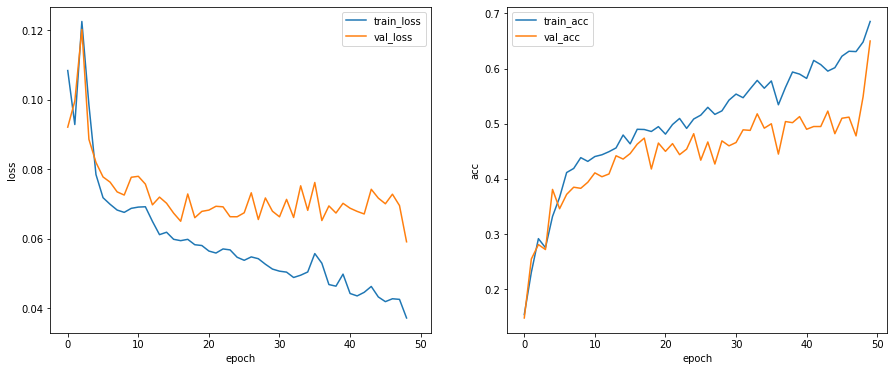

In [9]:
import matplotlib.pyplot as plt

fig,(loss, acc) = plt.subplots(ncols = 2, figsize=(15,6), sharex = True)

loss.plot(range(num_epochs-1),train_loss_list[1:],label='train_loss')
loss.plot(range(num_epochs-1),val_loss_list[1:],label='val_loss')
acc.plot(range(num_epochs),train_acc_list,label='train_acc')
acc.plot(range(num_epochs),val_acc_list,label='val_acc')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

acc.set_xlabel('epoch')
acc.set_ylabel('acc')

loss.legend()
acc.legend()

fig.show()

In [10]:
#テストデータで評価
def test_func(criterion, data_num, data_loader):
    test_loss = 0
    test_acc = 0

    for data in data_loader:
        
        text, label = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, label)
            test_loss += loss.item()
            test_acc += (output.argmax(1) == label).sum().item()
            
    return test_loss / data_num, test_acc / data_num

print('Checking the results of test dataset...')
test_loss, test_acc = test_func(criterion, len(test), test_loader)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0647(test)	|	Acc: 62.9%(test)
